# Import Data

In [ ]:
!pip install pygsheets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pygsheets
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway

In [ ]:
client = pygsheets.authorize(service_file='/content/refined-grammar-372209-b3fbc4b10ebf.json')
sh = client.open('ML Data')
cus_wks = sh.worksheet_by_title('Customer')
sale_wks = sh.worksheet_by_title('Sales')
product_wks = sh.worksheet_by_title('Product')

In [ ]:
customer = cus_wks.get_as_df()
sales = sale_wks.get_as_df()
product = product_wks.get_as_df()

In [ ]:
temp_df = pd.merge(customer,sales,right_on='CustomerKey',left_on='CustomerKey', how = 'right')
df = pd.merge(product,temp_df,right_on='ProductKey',left_on='ProductKey', how = 'right')

In [ ]:
df.columns

Index(['ProductKey', 'ProductSubcategoryKey', 'ProductSKU', 'ProductName',
       'ModelName', 'ProductDescription', 'ProductColor', 'ProductSize',
       'ProductStyle', 'ProductCost', 'ProductPrice', 'CustomerKey', 'Prefix',
       'FirstName', 'LastName', 'BirthDate', 'MaritalStatus', 'Gender',
       'EmailAddress', 'AnnualIncome', 'TotalChildren', 'EducationLevel',
       'Occupation', 'HomeOwner', 'OrderDate', 'StockDate', 'OrderNumber',
       'TerritoryKey', 'OrderLineItem', 'OrderQuantity'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56046 entries, 0 to 56045
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             56046 non-null  int64  
 1   ProductSubcategoryKey  56046 non-null  int64  
 2   ProductSKU             56046 non-null  object 
 3   ProductName            56046 non-null  object 
 4   ModelName              56046 non-null  object 
 5   ProductDescription     56046 non-null  object 
 6   ProductColor           56046 non-null  object 
 7   ProductSize            56046 non-null  object 
 8   ProductStyle           56046 non-null  object 
 9   ProductCost            56046 non-null  float64
 10  ProductPrice           56046 non-null  float64
 11  CustomerKey            56046 non-null  int64  
 12  Prefix                 56046 non-null  object 
 13  FirstName              56046 non-null  object 
 14  LastName               56046 non-null  object 
 15  Bi

# Data Preprocessing

## Datetime

In [ ]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%m/%d/%Y')
df['year'] = df['OrderDate'].dt.year
df['month'] = df['OrderDate'].dt.month
df['day'] = df['OrderDate'].dt.day
df['weekday'] = df['OrderDate'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

## Customer info

In [ ]:
df['AnnualIncome'] = df['AnnualIncome'].astype(str).str.replace(",","")
df['AnnualIncome'] = df['AnnualIncome'].astype(str).str.replace("$","")
df['AnnualIncome'] = df['AnnualIncome'].astype('float')

<ipython-input-9-3bf30f8be271>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['AnnualIncome'] = df['AnnualIncome'].astype(str).str.replace("$","")


In [ ]:
df['BirthDate'] = pd.to_datetime(df['BirthDate'], format='%m/%d/%Y')
df['age'] = [2017-i for i in df['BirthDate'].dt.year]

In [ ]:
df['is_male'] = [1 if i=='M' else 0 for i in df['Gender']]
df['have_home'] = [1 if i=='Y' else 0 for i in df['HomeOwner']]
df['have_child'] = [1 if i > 0 else 0 for i in df['TotalChildren']]

## Tổng giá trị đơn hàng

In [ ]:
df['total_bill'] = [i*j for i,j in zip(df['ProductPrice'],df['OrderQuantity'])]

## Gom nhóm theo ngày

In [ ]:
df_gb = df.groupby(['month','year','day','weekday']).agg({'total_bill':'sum','OrderNumber':'nunique',\
                                                          'CustomerKey':'nunique','AnnualIncome':'mean',\
                                                          'age':'mean','is_male':'sum','have_home':'sum',\
                                                          'have_child':sum}).reset_index()
df_gb.sort_values(['year','month','day','weekday'], inplace=True, ignore_index=True)

## Percentage

In [ ]:
df_gb['male_per'] = [i/j for i,j in zip(df_gb['is_male'],df_gb['CustomerKey'])]
df_gb['home_per'] = [i/j for i,j in zip(df_gb['have_home'],df_gb['CustomerKey'])]
df_gb['child_per'] = [i/j for i,j in zip(df_gb['have_child'],df_gb['CustomerKey'])]

## Rolling feature

In [ ]:
df_gb['rolling_mean_bill'] = df_gb.total_bill.rolling(window=7,closed = 'left').mean()
df_gb['rolling_std_bill'] = df_gb.total_bill.rolling(window=7,closed = 'left').std()

df_gb['rolling_mean_order'] = df_gb.OrderNumber.rolling(window=7,closed = 'left').mean()
df_gb['rolling_std_order'] = df_gb.OrderNumber.rolling(window=7,closed = 'left').std()

df_gb['rolling_mean_cus'] = df_gb.CustomerKey.rolling(window=7,closed = 'left').mean()
df_gb['rolling_std_cus'] = df_gb.CustomerKey.rolling(window=7,closed = 'left').std()

df_gb['rolling_mean_gender'] = df_gb.male_per.rolling(window=7,closed = 'left').mean()
df_gb['rolling_mean_home'] = df_gb.home_per.rolling(window=7,closed = 'left').mean()
df_gb['rolling_mean_child'] = df_gb.child_per.rolling(window=7,closed = 'left').mean()


## RSI

In [ ]:
# Define the time period for the RSI
period = 7

delta = df_gb['total_bill'].diff()
direction = np.where(delta > 0, 1, np.where(delta < 0, -1, 0))

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=period).mean()
avg_loss = loss.rolling(window=period).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

df_gb['rsi'] = rsi


In [ ]:
df_gb

month  year  day  weekday  total_bill  OrderNumber  CustomerKey  \
0        1  2015    1        3   8351.4564            4            4   
1        1  2015    2        4  14313.0800            4            4   
2        1  2015    3        5  28041.3200            8            8   
3        1  2015    4        6  17713.0700            5            5   
4        1  2015    5        7   7855.6382            3            3   
..     ...   ...  ...      ...         ...          ...          ...   
906      6  2017   26        7  65469.4464           78          185   
907      6  2017   27        1  54249.9720           72          172   
908      6  2017   28        2  71442.8481           87          213   
909      6  2017   29        3  58907.9356           67          169   
910      6  2017   30        4  43344.2324           51          134   

     AnnualIncome        age  is_male  ...  rolling_mean_bill  \
0    42500.000000  49.750000        3  ...                NaN   
1    55000.000000  45.500000        3  ...                NaN   
2    46250.000000  47.125000        7  ...                NaN   
3    58000.000000  50.400000        3  ...                NaN   
4    13333.333333  43.333333        1  ...                NaN   
..            ...        ...      ...  ...                ...   
906  56577.540107  48.775401       99  ...       65065.931029   
907  54651.162791  48.598837       83  ...       64661.980429   
908  56232.558140  49.283721      108  ...       63225.546571   
909  51104.651163  48.180233       98  ...       62225.053757   
910  53455.882353  47.470588       77  ...       61972.777829   

     rolling_std_bill  rolling_mean_order  rolling_std_order  \
0                 NaN                 NaN                NaN   
1                 NaN                 NaN                NaN   
2                 NaN                 NaN                NaN   
3                 NaN                 NaN                NaN   
4                 NaN                 NaN                NaN   
..                ...                 ...                ...   
906       9699.311082           74.714286           8.731443   
907       9600.693969           74.285714           8.440266   
908      10383.312280           74.142857           8.474050   
909       8904.352108           73.714286           7.565586   
910       8980.316527           72.857143           7.988086   

     rolling_mean_cus  rolling_std_cus  rolling_mean_gender  \
0                 NaN              NaN                  NaN   
1                 NaN              NaN                  NaN   
2                 NaN              NaN                  NaN   
3                 NaN              NaN                  NaN   
4                 NaN              NaN                  NaN   
..                ...              ...                  ...   
906        189.428571        18.265242             0.516476   
907        188.285714        18.254810             0.525566   
908        186.428571        19.277423             0.528094   
909        185.714286        17.960274             0.522547   
910        182.571429        18.787027             0.523113   

     rolling_mean_home  rolling_mean_child        rsi  
0                  NaN                 NaN        NaN  
1                  NaN                 NaN        NaN  
2                  NaN                 NaN        NaN  
3                  NaN                 NaN        NaN  
4                  NaN                 NaN        NaN  
..                 ...                 ...        ...  
906           0.673380            0.580863  48.254104  
907           0.658460            0.570612  44.300346  
908           0.656970            0.565157  46.162873  
909           0.657188            0.574504  48.973552  
910           0.653882            0.556797  47.118081  

[911 rows x 25 columns]

## Scaling

In [ ]:
train_data = df_gb[df_gb.columns.drop(['month','year','day','weekday','OrderNumber','CustomerKey',\
                                       'AnnualIncome','age','is_male','have_home','have_child',\
                                       'male_per','home_per','child_per','total_bill'])]
                                       
no_scale = df_gb[['month','year','day','weekday','OrderNumber','CustomerKey','AnnualIncome','age',\
                  'is_male','have_home','have_child','male_per','home_per','child_per','total_bill']]

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(train_data)
scaled_df = pd.DataFrame(scaled_data, columns=train_data.columns).add_prefix('S_')
train_col = scaled_df.columns
train_data = pd.concat([no_scale,scaled_df], axis=1)

## Correlation

<Axes: >

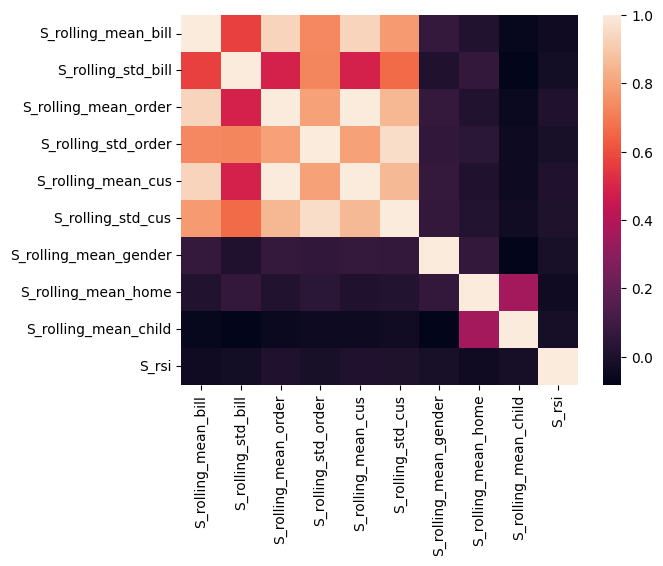

In [ ]:
corr_matrix = train_data.drop(columns=['month','year','day','weekday','OrderNumber','CustomerKey','AnnualIncome','age','is_male','have_home','have_child','male_per','home_per','child_per','total_bill'])._get_numeric_data().corr()
sns.heatmap(corr_matrix)

In [ ]:
# threshold above which is considered too high of a correlation
corr_threshold = 0.85

# Create correlation matrix
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than the correlation threshold
to_drop_corr = [column for column in upper.columns if any(upper[column] >= corr_threshold)]
print(to_drop_corr)

['S_rolling_mean_order', 'S_rolling_mean_cus', 'S_rolling_std_cus']


<ipython-input-21-3cb32e8b6766>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [ ]:
train_col.drop(to_drop_corr)

Index(['S_rolling_mean_bill', 'S_rolling_std_bill', 'S_rolling_std_order',
       'S_rolling_mean_gender', 'S_rolling_mean_home', 'S_rolling_mean_child',
       'S_rsi'],
      dtype='object')

In [ ]:
train_data.dropna(inplace=True)
df_gb.dropna(inplace=True)

# EDA

##Timeseries decomposition

###Year

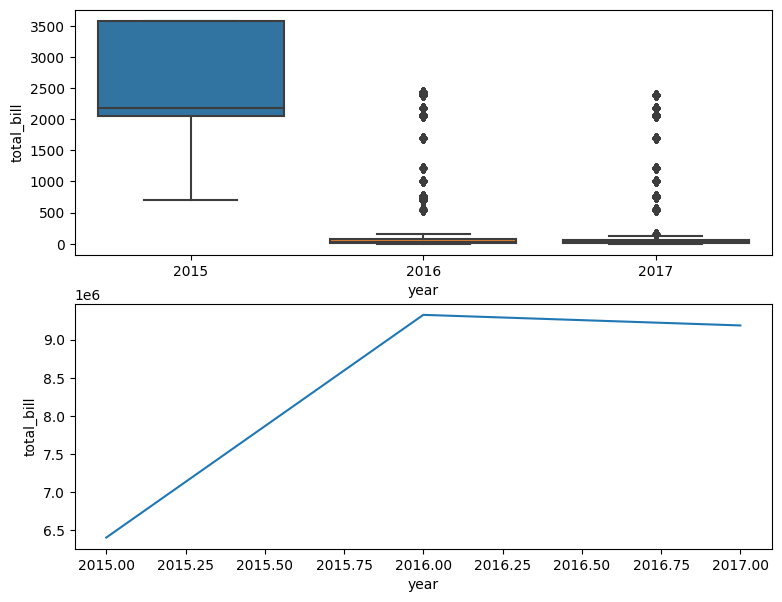

In [ ]:
yearly_agg = df.groupby('year')['total_bill'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='total_bill', data=df, ax=axs[0])
_ = sns.lineplot(x='year', y='total_bill', data=yearly_agg, ax=axs[1])

### Month

<Axes: xlabel='month', ylabel='total_bill'>

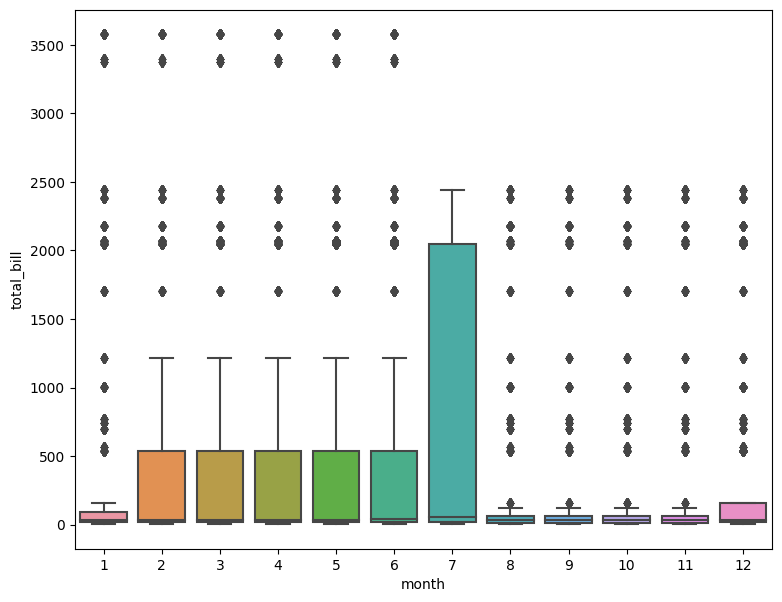

In [ ]:
monthly_agg = df.groupby('month')['total_bill'].sum().reset_index()
fig, axs = plt.subplots(nrows=1, figsize=(9,7))
sns.boxplot(x='month', y='total_bill', data=df)

### Date

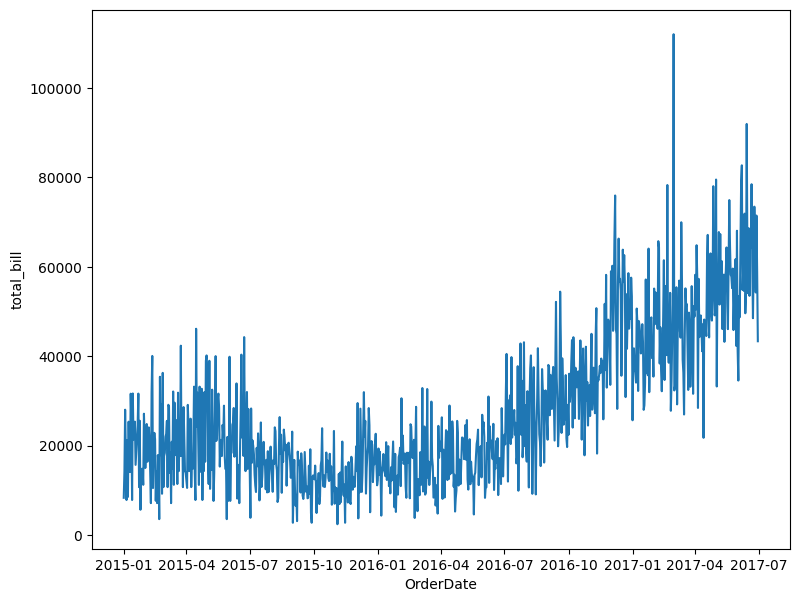

In [ ]:
monthly_agg = df.groupby('OrderDate')['total_bill'].sum().reset_index()
fig, axs = plt.subplots(nrows=1, figsize=(9,7))
_ = sns.lineplot(x='OrderDate', y='total_bill', data=monthly_agg)

###Weekday

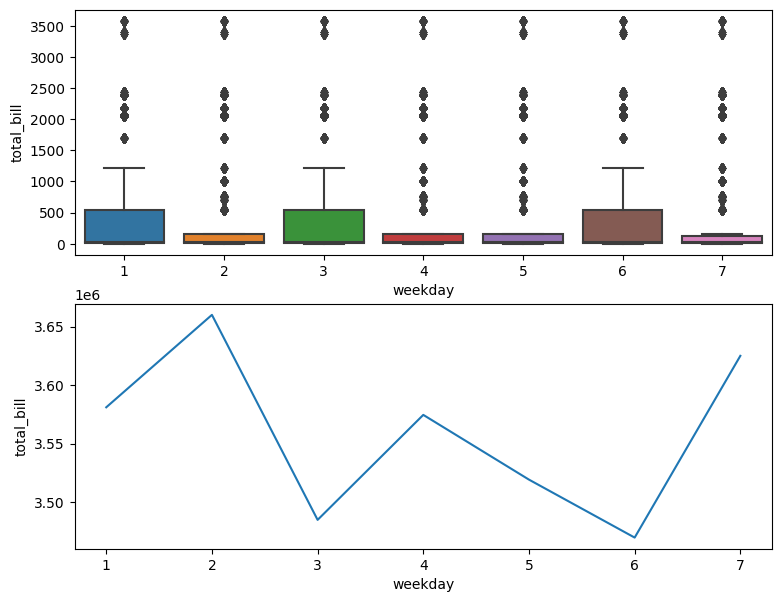

In [ ]:
wd_agg = df.groupby('weekday')['total_bill'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='weekday', y='total_bill', data=df, ax=axs[0])
_ = sns.lineplot(x='weekday', y='total_bill', data=wd_agg, ax=axs[1])

## MA

In [ ]:
dfgb = df_gb.copy()

In [ ]:
dfgb['OrderDate'] = [str(i)+'-'+str(j)+'-'+str(k) for i,j,k in zip(dfgb['day'],dfgb['month'],dfgb['year'])]

In [ ]:
mse_lst = []
mae_lst = []
model_lst = []

Text(0.5, 1.0, 'Forecast EMA')

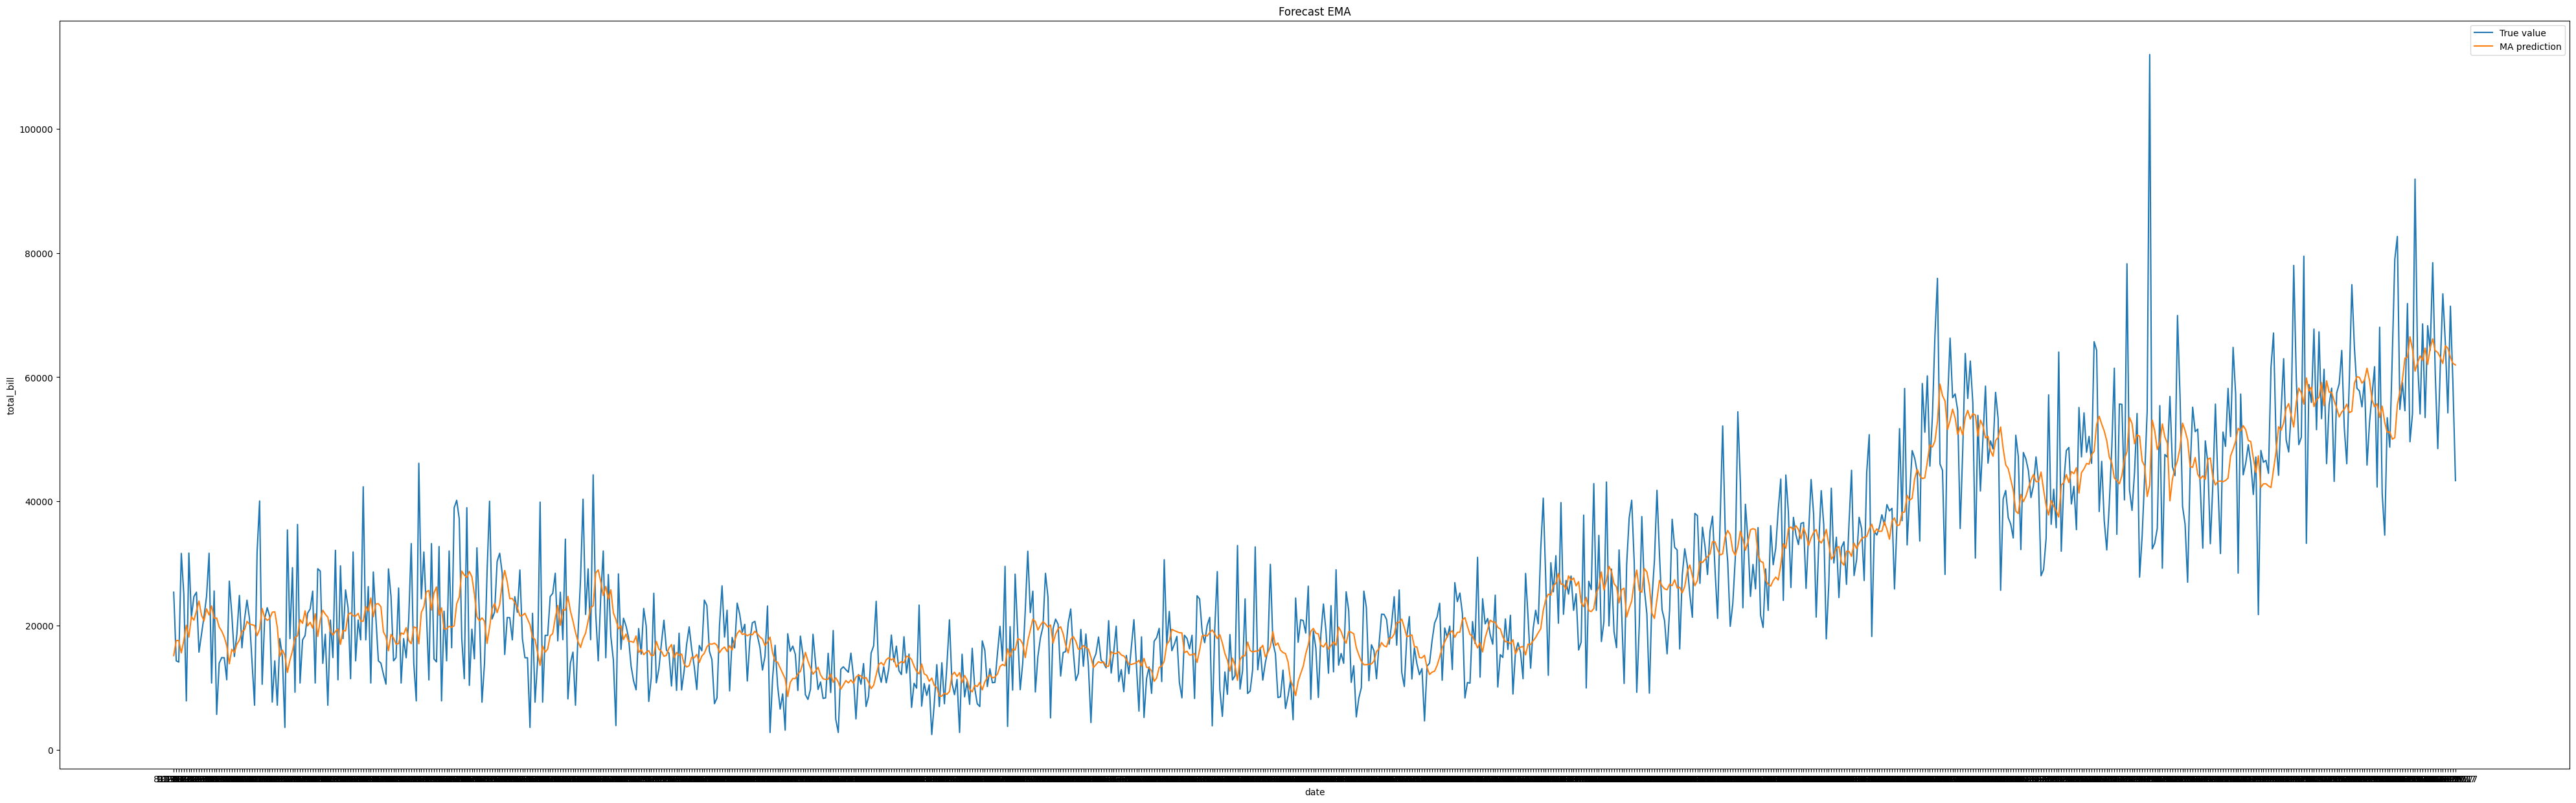

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(dfgb['OrderDate'], dfgb['total_bill'], label ='True value')
plt.plot(dfgb['OrderDate'], dfgb['rolling_mean_bill'], label = 'MA prediction')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_bill')
plt.title('Forecast EMA')

In [ ]:
mse_lst.append(mean_squared_error(dfgb['total_bill'],dfgb['rolling_mean_bill']))
mae_lst.append(mean_absolute_error(dfgb['total_bill'],dfgb['rolling_mean_bill']))
model_lst.append('MA')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

MA
MAE:6848.75683596713
MSE:83388914.67321005


## EMA

In [ ]:
# Define the number of days for the EMA
num_days = 7

# Calculate the EMA using the pandas `ewm` function
ema = dfgb['total_bill'].ewm(span=num_days, adjust=True).mean()

# Add the EMA to your dataframe
dfgb['ema'] = ema
dfgb

month  year  day  weekday  total_bill  OrderNumber  CustomerKey  \
7        1  2015    8        3  25365.4282            8            8   
8        1  2015    9        4  14313.0800            4            4   
9        1  2015   10        5  14109.8000            4            4   
10       1  2015   11        6  31619.5900            9            9   
11       1  2015   12        7  25047.8900            7            7   
..     ...   ...  ...      ...         ...          ...          ...   
906      6  2017   26        7  65469.4464           78          185   
907      6  2017   27        1  54249.9720           72          172   
908      6  2017   28        2  71442.8481           87          213   
909      6  2017   29        3  58907.9356           67          169   
910      6  2017   30        4  43344.2324           51          134   

     AnnualIncome        age  is_male  ...  rolling_mean_order  \
7    47500.000000  48.750000        5  ...            4.857143   
8    55000.000000  45.500000        0  ...            5.428571   
9    47500.000000  44.250000        2  ...            5.428571   
10   37777.777778  45.888889        7  ...            4.857143   
11   41428.571429  43.428571        3  ...            5.428571   
..            ...        ...      ...  ...                 ...   
906  56577.540107  48.775401       99  ...           74.714286   
907  54651.162791  48.598837       83  ...           74.285714   
908  56232.558140  49.283721      108  ...           74.142857   
909  51104.651163  48.180233       98  ...           73.714286   
910  53455.882353  47.470588       77  ...           72.857143   

     rolling_std_order  rolling_mean_cus  rolling_std_cus  \
7             1.676163          4.857143         1.676163   
8             1.988060          5.428571         1.988060   
9             1.988060          5.428571         1.988060   
10            1.676163          4.857143         1.676163   
11            2.299068          5.428571         2.299068   
..                 ...               ...              ...   
906           8.731443        189.428571        18.265242   
907           8.440266        188.285714        18.254810   
908           8.474050        186.428571        19.277423   
909           7.565586        185.714286        17.960274   
910           7.988086        182.571429        18.787027   

     rolling_mean_gender  rolling_mean_home  rolling_mean_child        rsi  \
7               0.627381           0.573810            0.490476  60.273078   
8               0.609524           0.573810            0.508333  50.000000   
9               0.502381           0.573810            0.544048  40.634185   
10              0.448810           0.573810            0.579762  58.525765   
11              0.474206           0.567460            0.541667  60.982641   
..                   ...                ...                 ...        ...   
906             0.516476           0.673380            0.580863  48.254104   
907             0.525566           0.658460            0.570612  44.300346   
908             0.528094           0.656970            0.565157  46.162873   
909             0.522547           0.657188            0.574504  48.973552   
910             0.523113           0.653882            0.556797  47.118081   

     OrderDate           ema  
7     8-1-2015  25365.428200  
8     9-1-2015  19049.800657  
9    10-1-2015  16913.584157  
10   11-1-2015  22291.780579  
11   12-1-2015  23195.191606  
..         ...           ...  
906  26-6-2017  64697.496203  
907  27-6-2017  62085.615153  
908  28-6-2017  64424.923389  
909  29-6-2017  63045.676442  
910  30-6-2017  58120.315432  

[904 rows x 27 columns]

Text(0.5, 1.0, 'Forecast EMA')

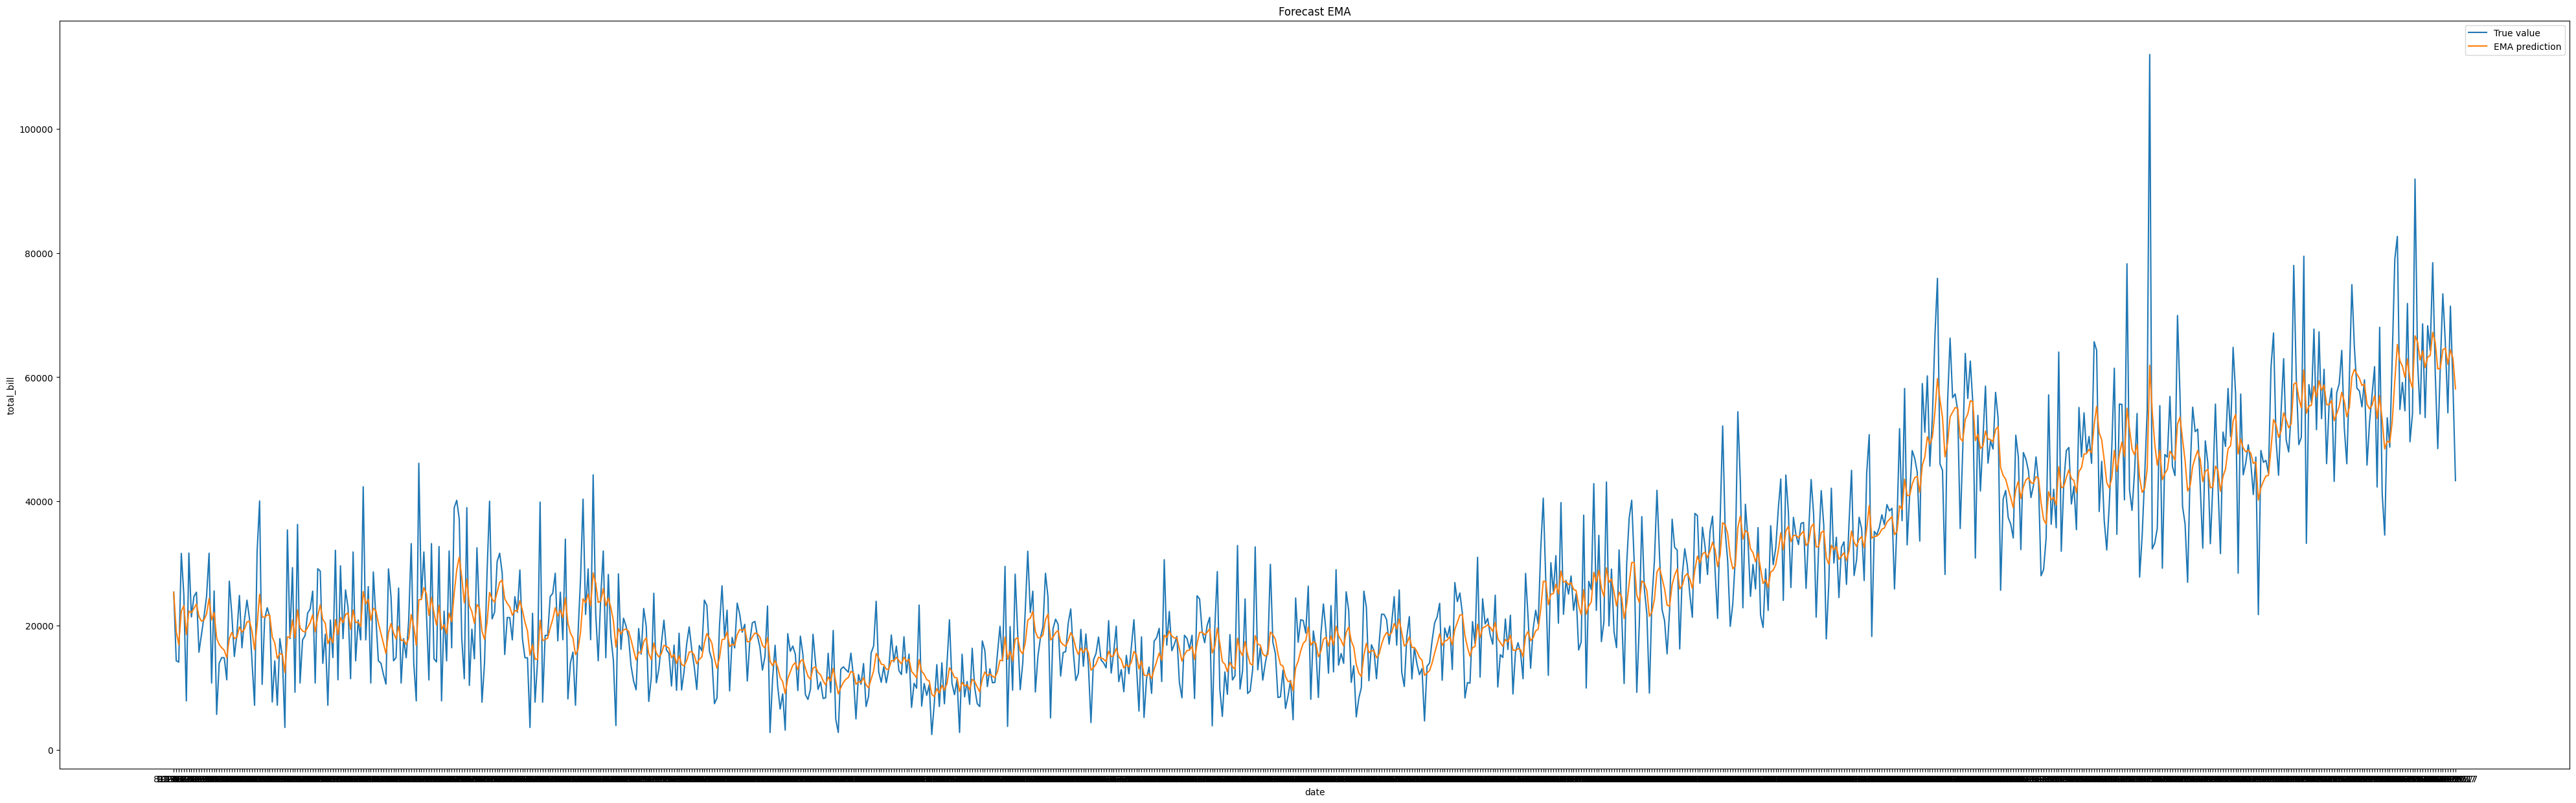

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(dfgb['OrderDate'], dfgb['total_bill'], label ='True value')
plt.plot(dfgb['OrderDate'], dfgb['ema'], label ='EMA prediction')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_bill')
plt.title('Forecast EMA')

In [ ]:
mse_lst.append(mean_squared_error(dfgb['total_bill'],dfgb['ema']))
mae_lst.append(mean_absolute_error(dfgb['total_bill'],dfgb['ema']))
model_lst.append('EMA')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

EMA
MAE:5143.066816073632
MSE:47052381.350058496


## AutoReg

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(dfgb['total_bill'],lags=7).fit()

# Use the fitted model to make predictions on the testing data
predictions = model.predict(start=dfgb.index[0], end=dfgb.index[-1])

dfgb['autoreg'] = predictions

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


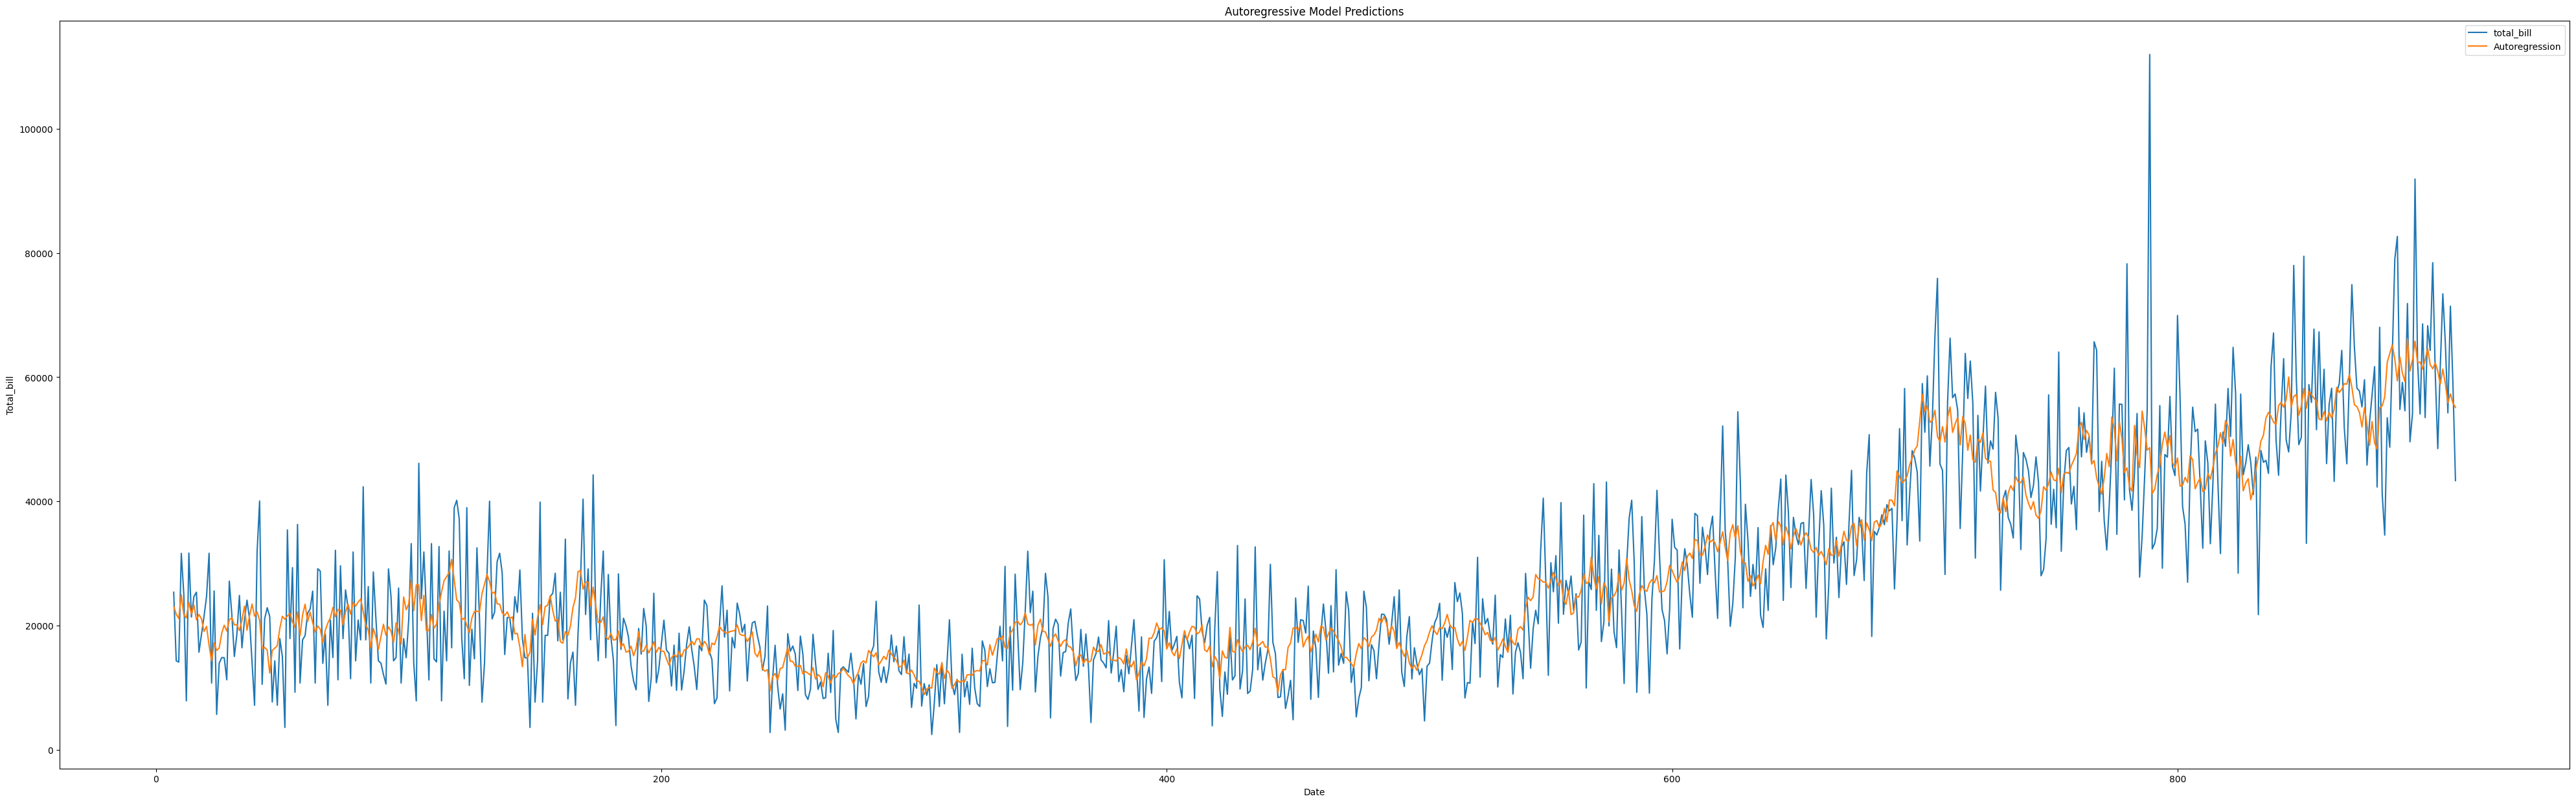

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(dfgb.index, dfgb['total_bill'], label='total_bill')
plt.plot(predictions.index, predictions, label='Autoregression')
plt.legend(loc='best')
plt.title('Autoregressive Model Predictions')
plt.xlabel('Date')
plt.ylabel('Total_bill')
plt.show()

In [ ]:
mse_lst.append(mean_squared_error(dfgb['total_bill'],dfgb['autoreg']))
mae_lst.append(mean_absolute_error(dfgb['total_bill'],dfgb['autoreg']))
model_lst.append('AutoReg')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

AutoReg
MAE:6000.889916790978
MSE:63247582.72123052


## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dfgb['total_bill'], order=(1,1,1)).fit()

# Use the fitted model to make predictions on the testing data
predictions = model.predict(start=dfgb.index[0], end=dfgb.index[-1])

dfgb['arima'] = predictions

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


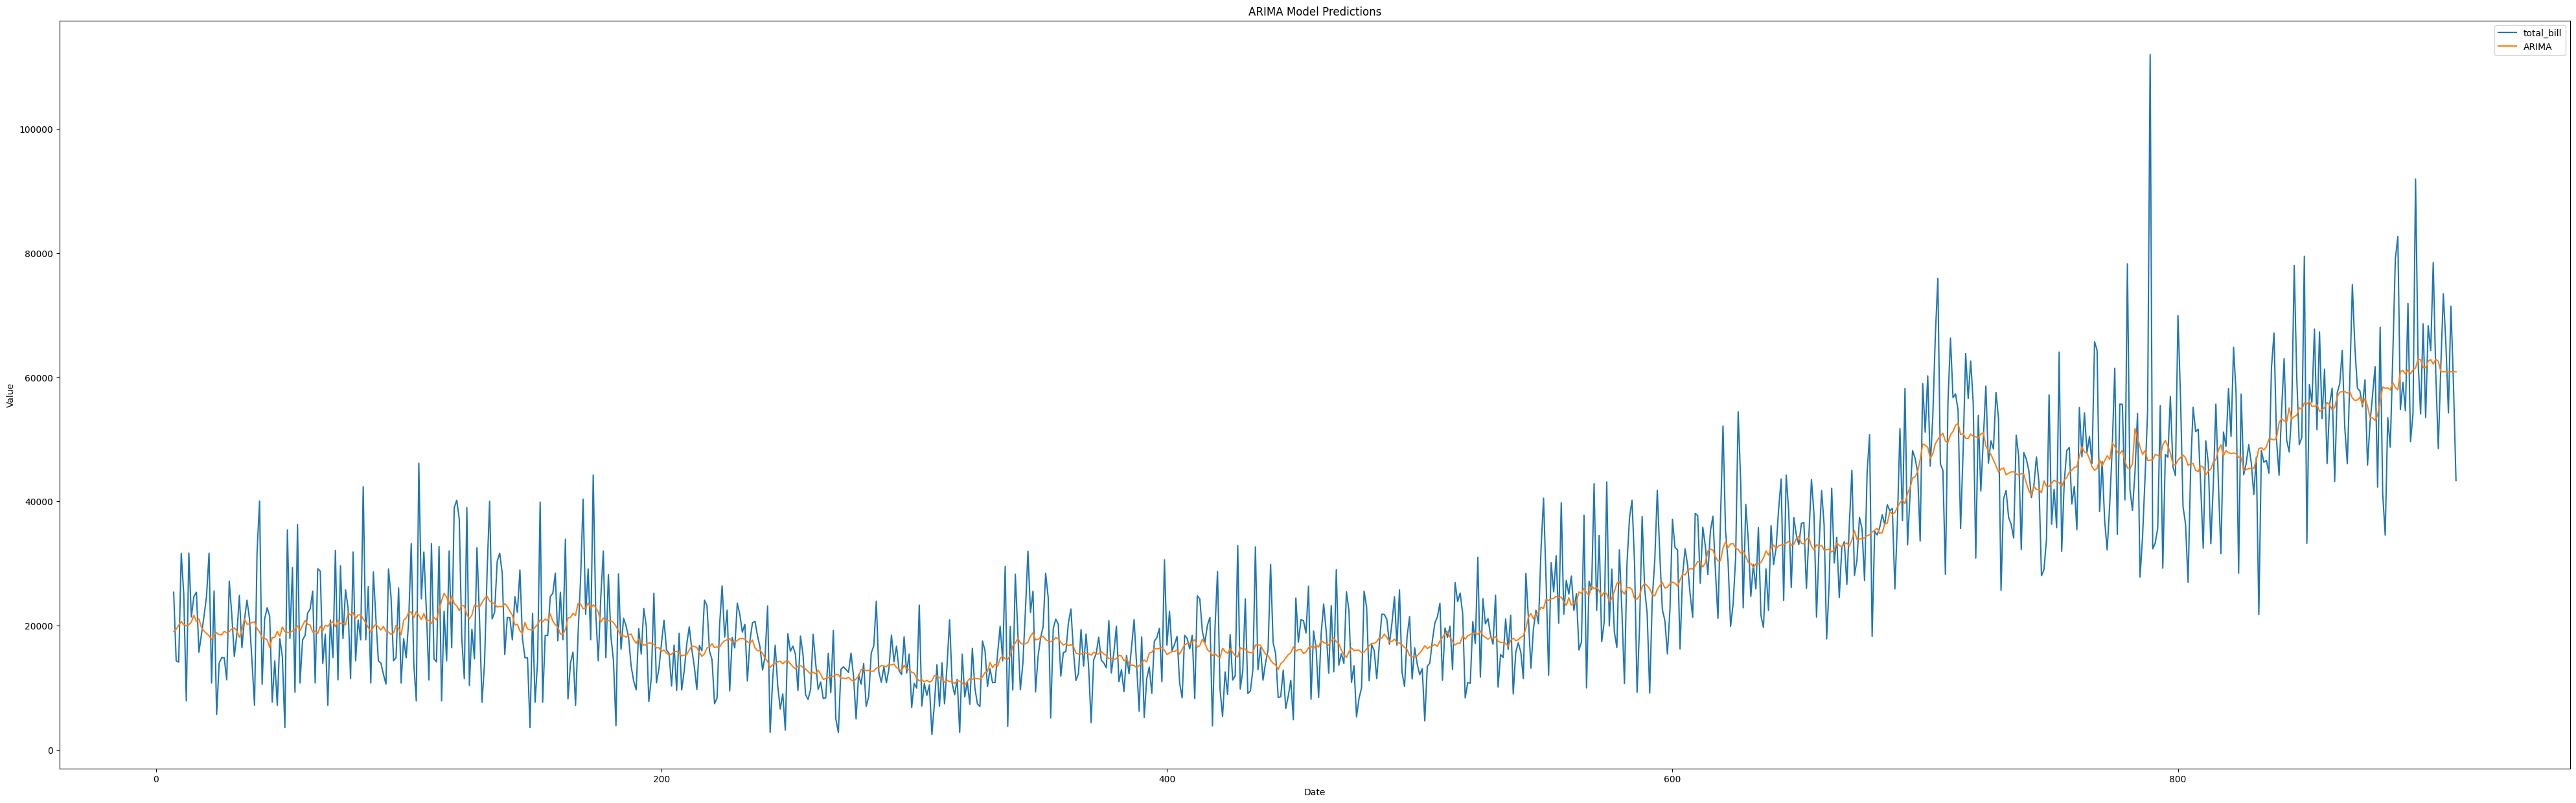

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(dfgb.index, dfgb['total_bill'], label='total_bill')
plt.plot(predictions.index, predictions, label='ARIMA')
plt.legend(loc='best')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
mse_lst.append(mean_squared_error(dfgb['total_bill'],dfgb['arima']))
mae_lst.append(mean_absolute_error(dfgb['total_bill'],dfgb['arima']))
model_lst.append('ARIMA')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

ARIMA
MAE:6216.605856110092
MSE:69150893.43518661


# Machine Learning

## Split data

In [ ]:
train_col

Index(['S_rolling_mean_bill', 'S_rolling_std_bill', 'S_rolling_mean_order',
       'S_rolling_std_order', 'S_rolling_mean_cus', 'S_rolling_std_cus',
       'S_rolling_mean_gender', 'S_rolling_mean_home', 'S_rolling_mean_child',
       'S_rsi'],
      dtype='object')

In [ ]:
output = train_data[['total_bill']]
input = train_data[train_col]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(input,output, test_size = 0.3, random_state=1)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632 entries, 779 to 44
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   S_rolling_mean_bill    632 non-null    float64
 1   S_rolling_std_bill     632 non-null    float64
 2   S_rolling_mean_order   632 non-null    float64
 3   S_rolling_std_order    632 non-null    float64
 4   S_rolling_mean_cus     632 non-null    float64
 5   S_rolling_std_cus      632 non-null    float64
 6   S_rolling_mean_gender  632 non-null    float64
 7   S_rolling_mean_home    632 non-null    float64
 8   S_rolling_mean_child   632 non-null    float64
 9   S_rsi                  632 non-null    float64
dtypes: float64(10)
memory usage: 54.3 KB


## Linear Regression

In [ ]:
## Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_predict_li = model.predict(x_test)
print('MSE:', mean_squared_error(y_test,y_predict_li))
print('MAE:',mean_absolute_error(y_test,y_predict_li))
print('R2:',r2_score(y_test,y_predict_li))

MSE: 39102626.562452555
MAE: 4905.573760164137
R2: 0.8616368591611696


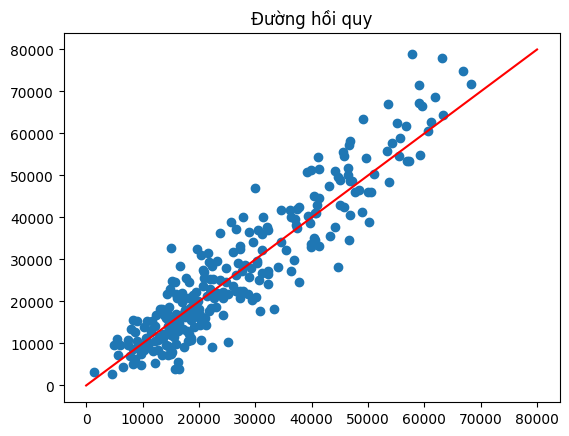

In [ ]:
plt.scatter(y_predict_li,y_test)
plt.plot([0,80_000],[0,80_000],color = 'r')
plt.title('Đường hồi quy')
plt.show()

<ipython-input-49-995f1d2668f9>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_train,hist = False,label = 'actual')
<ipython-input-49-995f1d2668f9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model.predict(x_train), hist = False, label ='predict',ax = ax1)


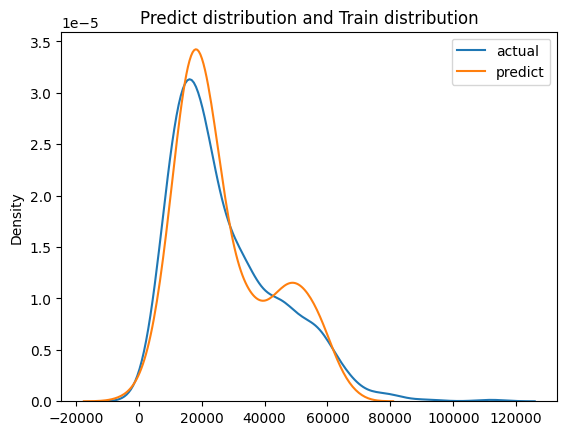

In [ ]:
import seaborn as sns
plt.title('Predict distribution and Train distribution')
ax1 = sns.distplot(y_train,hist = False,label = 'actual')
sns.distplot(model.predict(x_train), hist = False, label ='predict',ax = ax1)
plt.legend()

In [ ]:
ml_pred = model.predict(train_data[train_col])
train_data['lin_pred'] = ml_pred

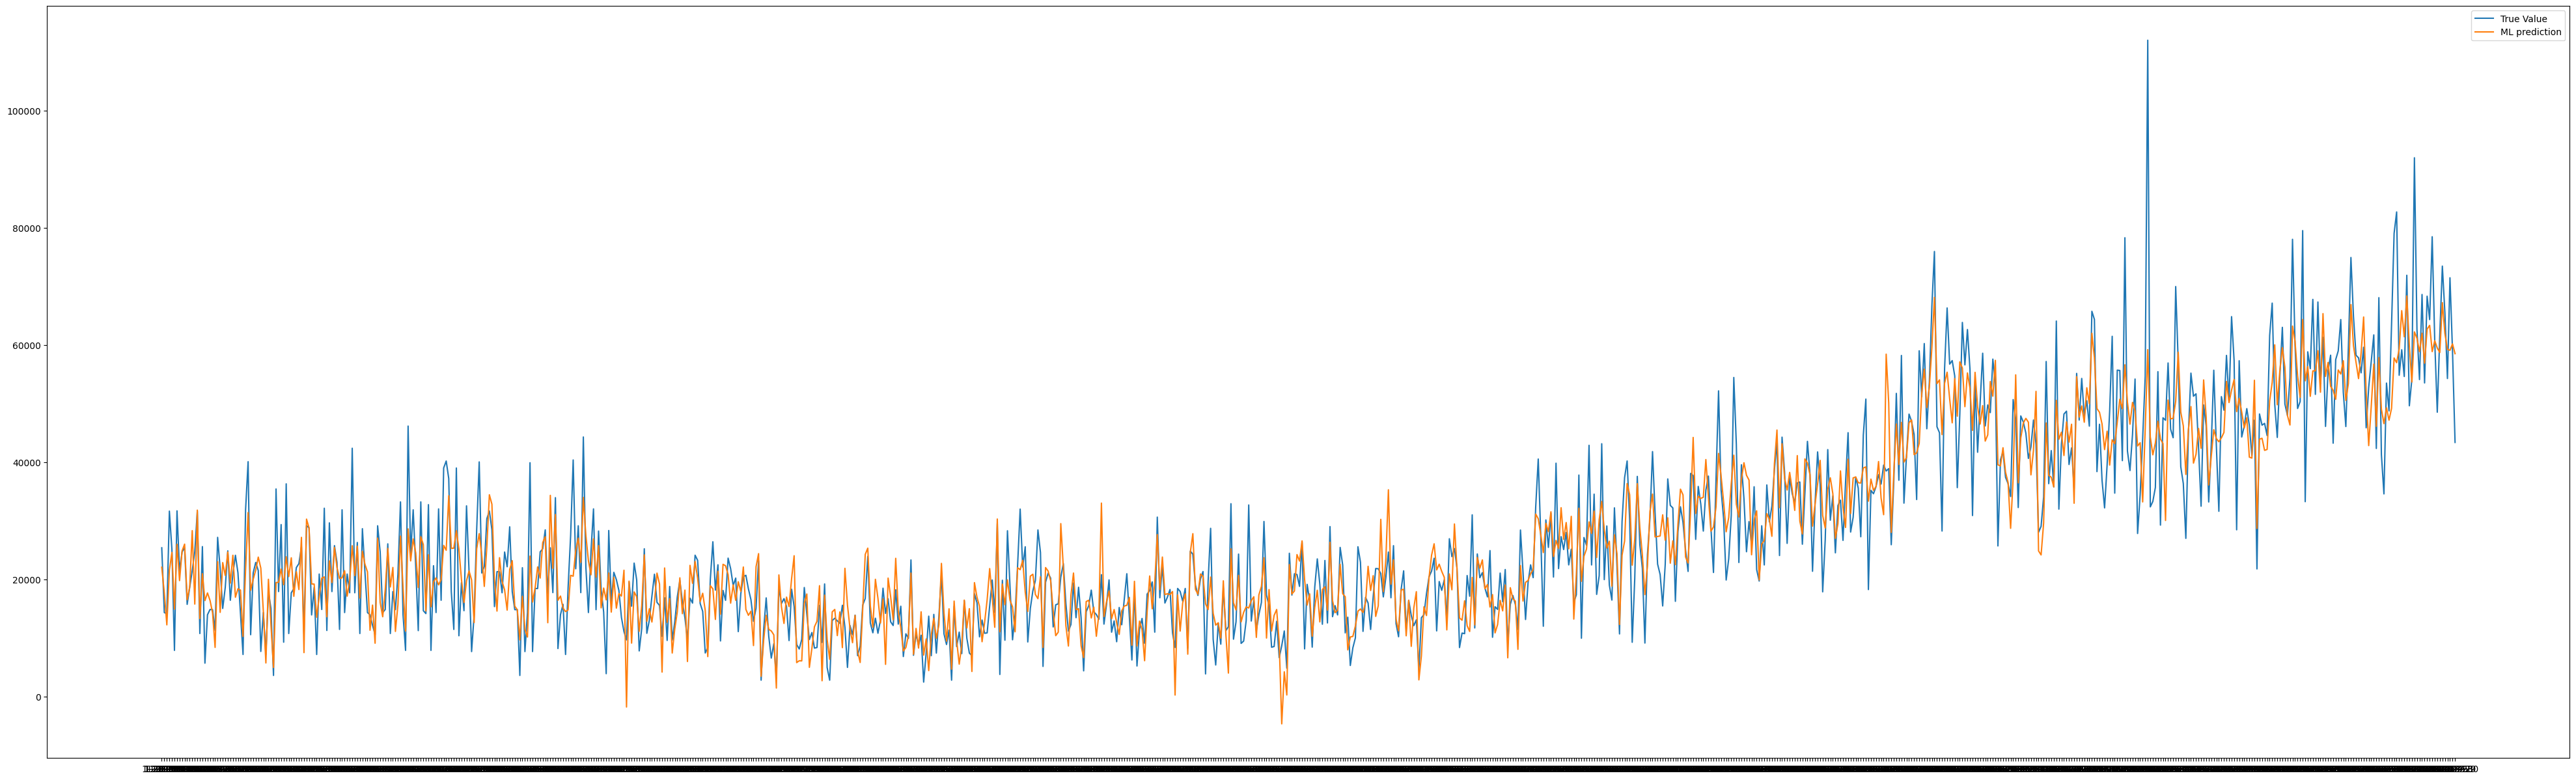

In [ ]:
train_data['month_year_date'] = [str(i)+'-'+str(j)+'-'+str(k) for i,j,k in zip(train_data['month'],train_data['year'],train_data['day'])]

plt.figure(figsize=(50,15))
plt.plot(train_data['month_year_date'].values, train_data['total_bill'].values, label="True Value")
plt.plot(train_data['month_year_date'].values, train_data['lin_pred'].values, label="ML prediction")

plt.legend()
plt.show()

In [ ]:
mse_lst.append(mean_squared_error(train_data['total_bill'],train_data['lin_pred']))
mae_lst.append(mean_absolute_error(train_data['total_bill'],train_data['lin_pred']))
model_lst.append('LinearRegression')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

LinearRegression
MAE:4883.085353874862
MSE:43039676.8961422


##ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1)
elastic_net.fit(x_train, y_train)

y_pred = elastic_net.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mean_squared_error(y_test,y_pred))
print('MAE:',mean_absolute_error(y_test,y_pred))
print('R2:',r2_score(y_test,y_pred))

MSE: 43231834.869703226
MAE: 5135.72100533715
R2: 0.8470258143083003


In [ ]:
elas_pred = elastic_net.predict(train_data[train_col])
train_data['elas_pred'] = elas_pred

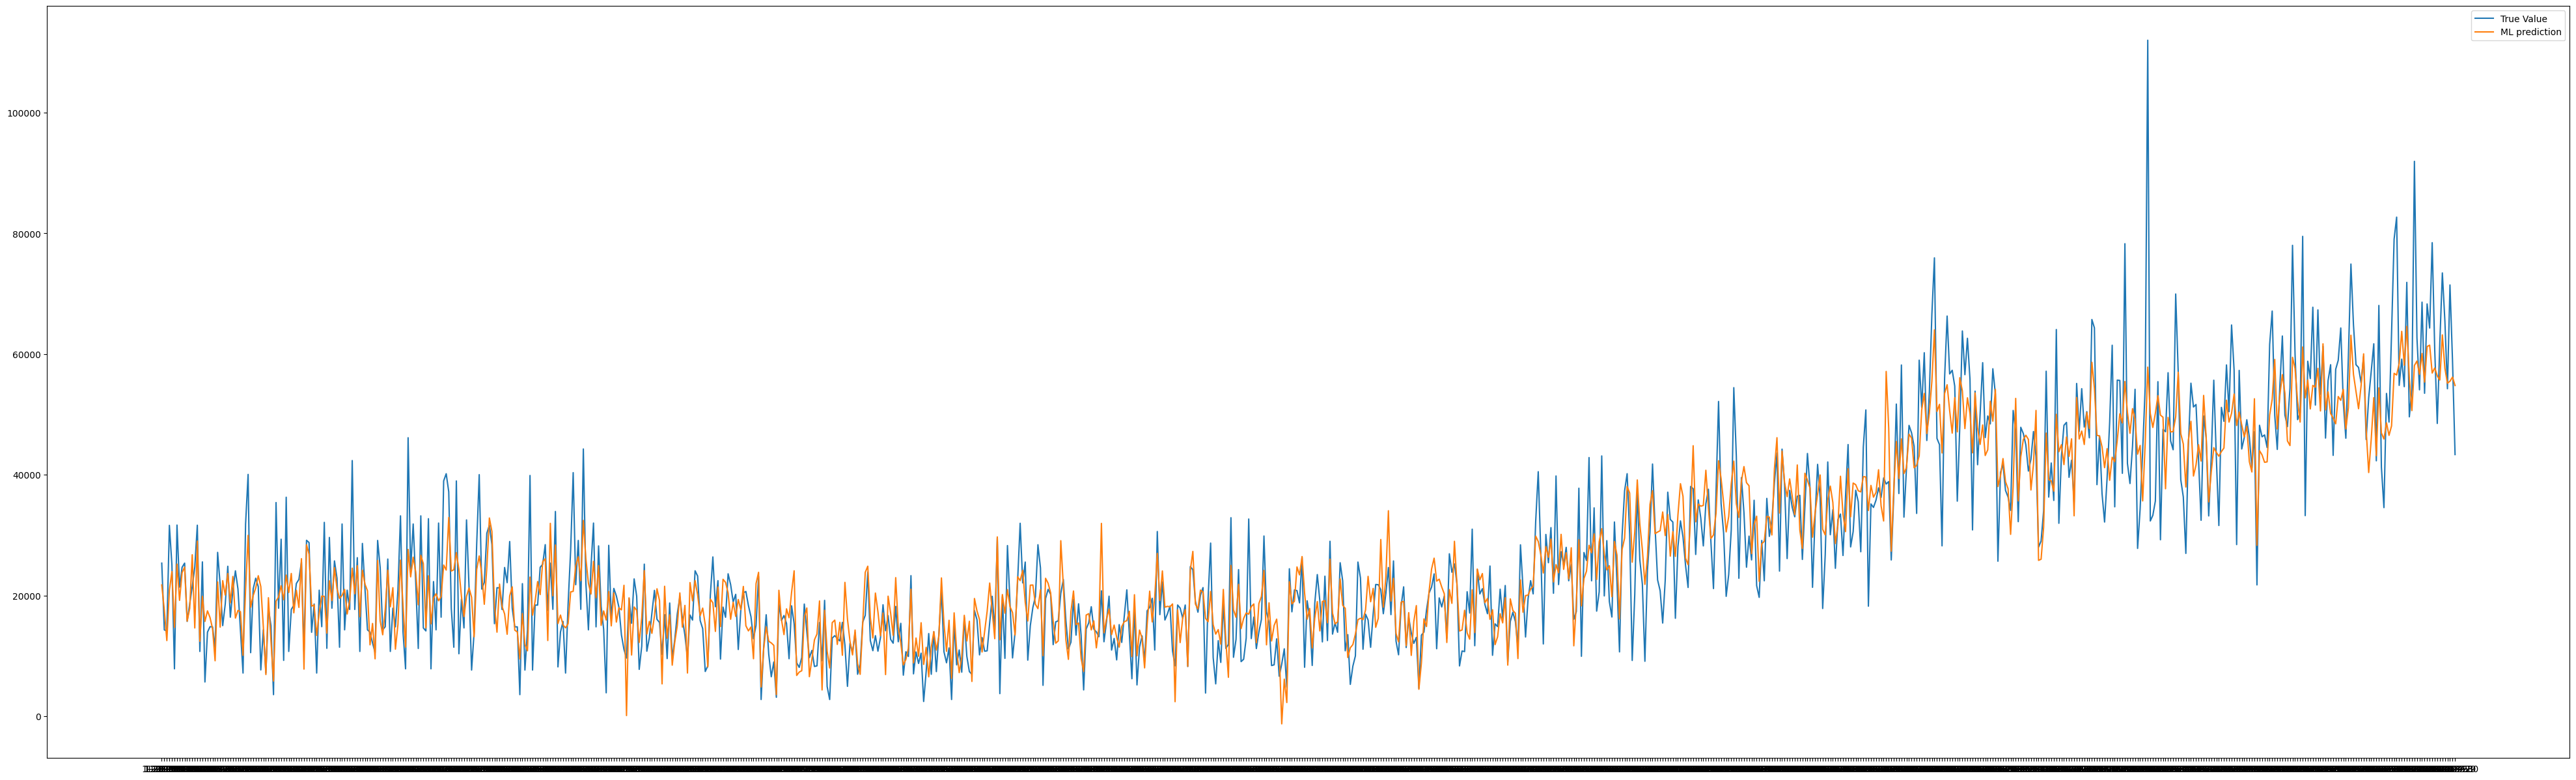

In [ ]:
plt.figure(figsize=(50,15))

plt.plot(train_data['month_year_date'].values, train_data['total_bill'].values, label="True Value")
plt.plot(train_data['month_year_date'].values, train_data['elas_pred'].values, label="ML prediction")

plt.legend()
plt.show()

In [ ]:
mse_lst.append(mean_squared_error(train_data['total_bill'],train_data['elas_pred']))
mae_lst.append(mean_absolute_error(train_data['total_bill'],train_data['elas_pred']))
model_lst.append('ElasticNet')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

ElasticNet
MAE:5003.442355843776
MSE:45867592.91885623


## GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.022, max_depth=3)
model.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.022)

In [ ]:
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mean_squared_error(y_test,y_pred))
print('MAE:',mean_absolute_error(y_test,y_pred))
print('R2:',r2_score(y_test,y_pred))

MSE: 51625940.50323122
MAE: 5606.864427870124
R2: 0.8173235942251333


In [ ]:
GradientBoosting_pred = model.predict(train_data[train_col])
train_data['GradientBoosting_pred'] = GradientBoosting_pred

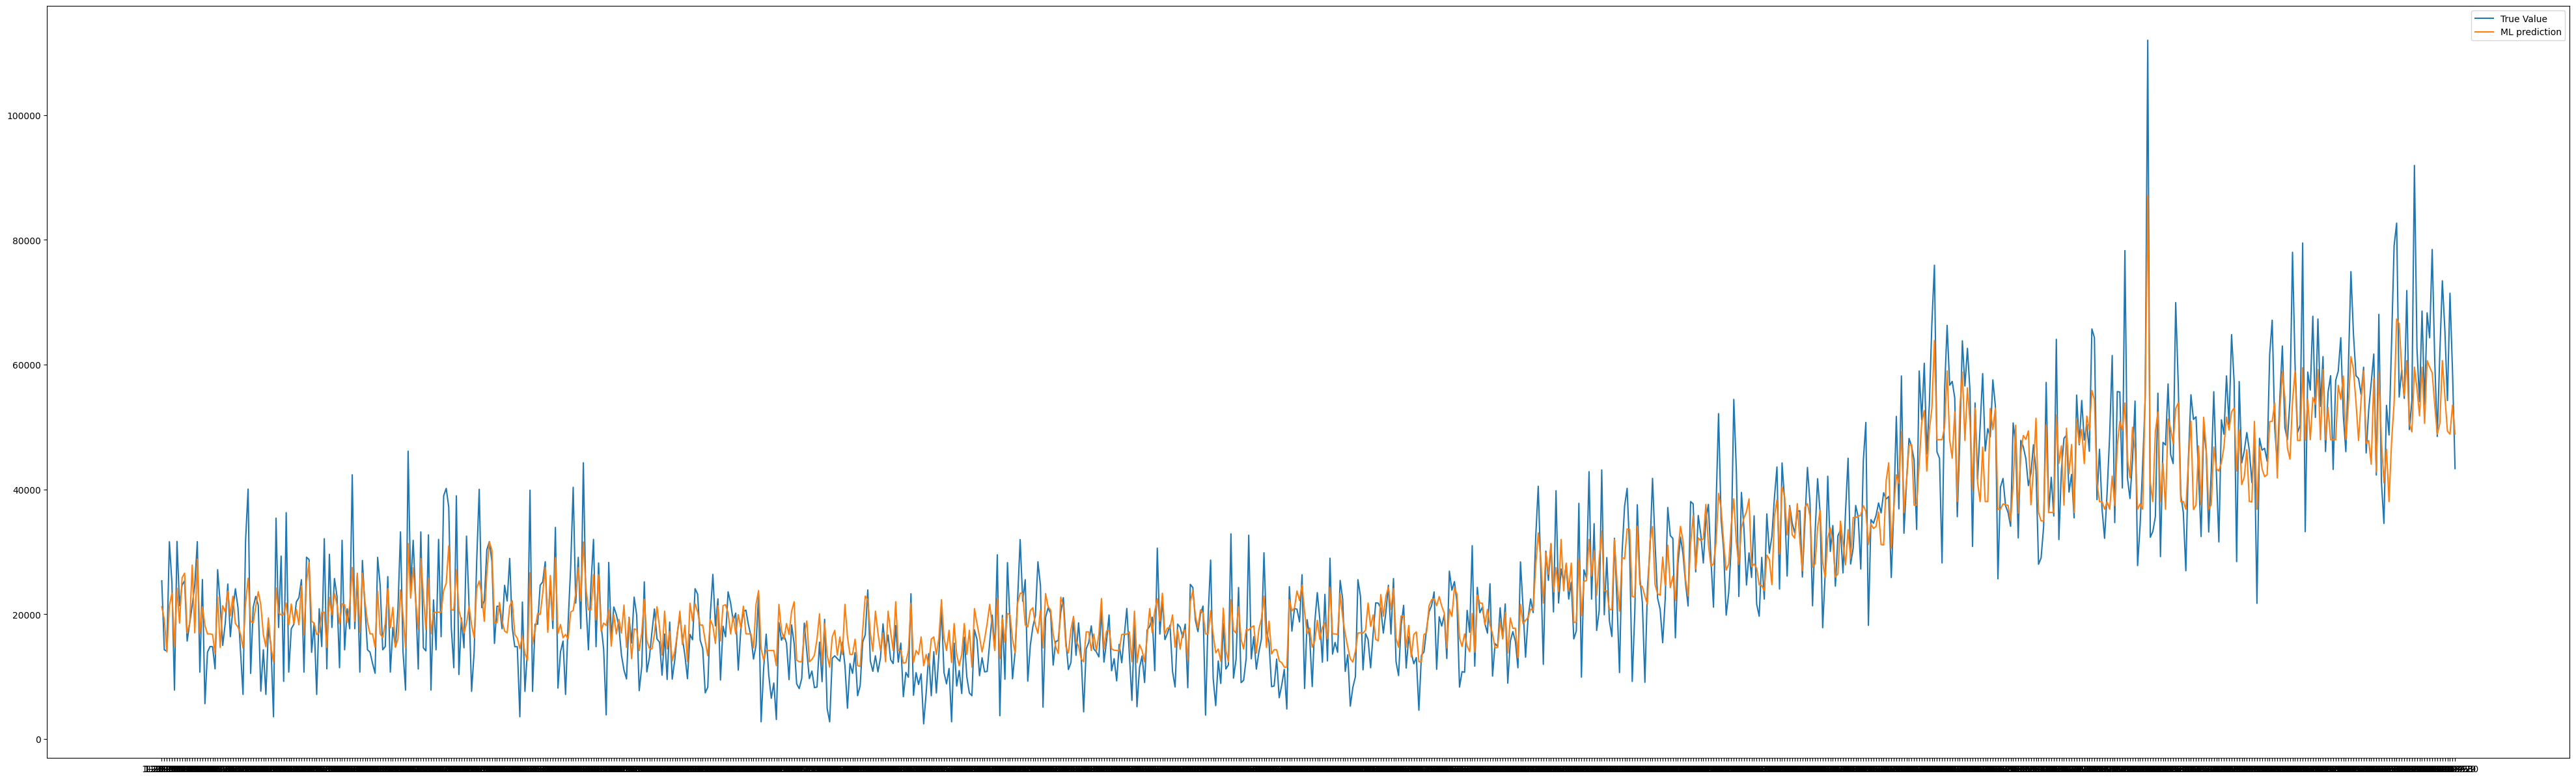

In [ ]:
plt.figure(figsize=(50,15))

plt.plot(train_data['month_year_date'].values, train_data['total_bill'].values, label="True Value")
plt.plot(train_data['month_year_date'].values, train_data['GradientBoosting_pred'].values, label="ML prediction")

plt.legend()
plt.show()

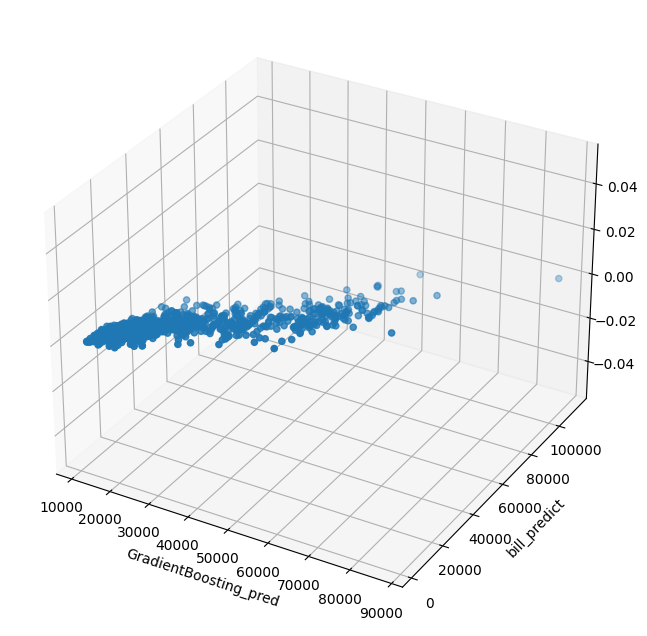

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax4 = fig.add_subplot(1,1,1, projection='3d')
ax4.set_xlabel("GradientBoosting_pred")
ax4.set_ylabel("bill_predict")
ax4.scatter(train_data['GradientBoosting_pred'].values, train_data['total_bill'].values)
plt.show()

In [ ]:
mse_lst.append(mean_squared_error(train_data['total_bill'],train_data['GradientBoosting_pred']))
mae_lst.append(mean_absolute_error(train_data['total_bill'],train_data['GradientBoosting_pred']))
model_lst.append('GradientBoosting')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

GradientBoosting
MAE:4830.464875369504
MSE:40400247.77896728


# Deep Learning

In [ ]:
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L1L2
import tensorflow as tf
from keras.optimizers import SGD
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.layers import Input, concatenate
from keras.models import Model

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# Reshape the input data to 3D array for LSTM
x_train_reshaped = x_train.values.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_reshaped = x_test.values.reshape(x_test.shape[0], 1, x_test.shape[1])

In [ ]:
y_train_test = y_train.copy()
y_train_test = y_train_test.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

In [ ]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    weight_decay=None,
    clipnorm=True,
    clipvalue=1.0,
    global_clipnorm=None,
    use_ema=True,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam'
)

In [ ]:
model = Sequential()
model.add(tf.keras.layers.LSTM(1024, activation='relu', input_shape=(1, x_train.shape[1]), return_sequences=True))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(LSTM(512,activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(Dense(1,'relu'))
model.compile(optimizer=adam, loss=MeanAbsoluteError())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1024)           4239360   
                                                                 
 dense (Dense)               (None, 1, 1024)           1049600   
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [ ]:
# Train the LSTM model
model.fit(x_train_reshaped, y_train_test, epochs=500, batch_size=64,validation_data=(x_test_reshaped, y_test_reshaped), callbacks=[early_stopping])

Epoch 1/500
10/10 [==============================] - 9s 291ms/step - loss: 27416.5703 - val_loss: 27499.2324
Epoch 2/500
10/10 [==============================] - 2s 250ms/step - loss: 27315.8379 - val_loss: 26932.6602
Epoch 3/500
10/10 [==============================] - 3s 251ms/step - loss: 24244.2168 - val_loss: 17735.5586
Epoch 4/500
10/10 [==============================] - 3s 285ms/step - loss: 13817.8877 - val_loss: 22774.8340
Epoch 5/500
10/10 [==============================] - 3s 299ms/step - loss: 14561.6836 - val_loss: 9671.8789
Epoch 6/500
10/10 [==============================] - 2s 240ms/step - loss: 8504.0684 - val_loss: 8754.1582
Epoch 7/500
10/10 [==============================] - 2s 240ms/step - loss: 7586.8110 - val_loss: 8129.3481
Epoch 8/500
10/10 [==============================] - 3s 258ms/step - loss: 6859.2500 - val_loss: 6979.1465
Epoch 9/500
10/10 [==============================] - 3s 311ms/step - loss: 6222.4321 - val_loss: 6472.0093
Epoch 10/500
10/10 [========

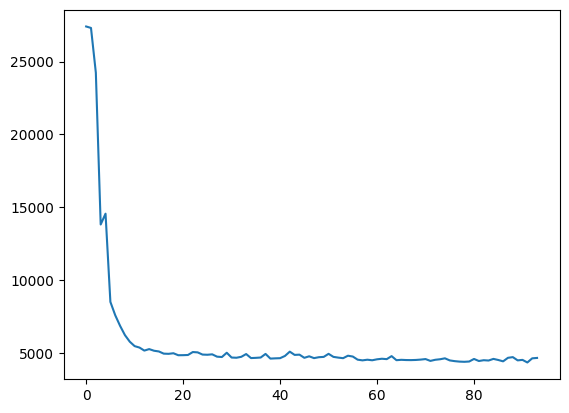

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
# Predict on the test data
y_pred = model.predict(x_train_reshaped)


# Evaluate the model
mse = mean_squared_error(y_train_test, y_pred)
mae = mean_absolute_error(y_train_test, y_pred)
r2 = r2_score(y_train_test, y_pred)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R2 Score:', r2)

20/20 [==============================] - 1s 21ms/step
Mean Squared Error (MSE): 38893421.44177594
Mean Absolute Error (MAE): 4313.049484335443
R2 Score: 0.8628479261318911


In [ ]:
# Predict on the test data
y_pred = model.predict(x_test_reshaped)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R2 Score:', r2)

9/9 [==============================] - 0s 20ms/step
Mean Squared Error (MSE): 40215527.392996706
Mean Absolute Error (MAE): 4955.938063706341
R2 Score: 0.8576989023563935


In [ ]:
# Predict on the test data
pred = model.predict(train_data[train_col].values.reshape(train_data[train_col].shape[0], 1, train_data[train_col].shape[1]))


# Evaluate the model
mse = mean_squared_error(train_data['total_bill'].values, pred)
mae = mean_absolute_error(train_data['total_bill'].values, pred)
r2 = r2_score(train_data['total_bill'].values, pred)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R2 Score:', r2)

29/29 [==============================] - 1s 20ms/step
Mean Squared Error (MSE): 39291223.56507389
Mean Absolute Error (MAE): 4506.485006618156
R2 Score: 0.8613031346744462


In [ ]:
dl_pred = model.predict(train_data[train_col].values.reshape(train_data[train_col].shape[0], 1, train_data[train_col].shape[1]))
train_data['LSTM_pred'] = dl_pred

29/29 [==============================] - 1s 20ms/step


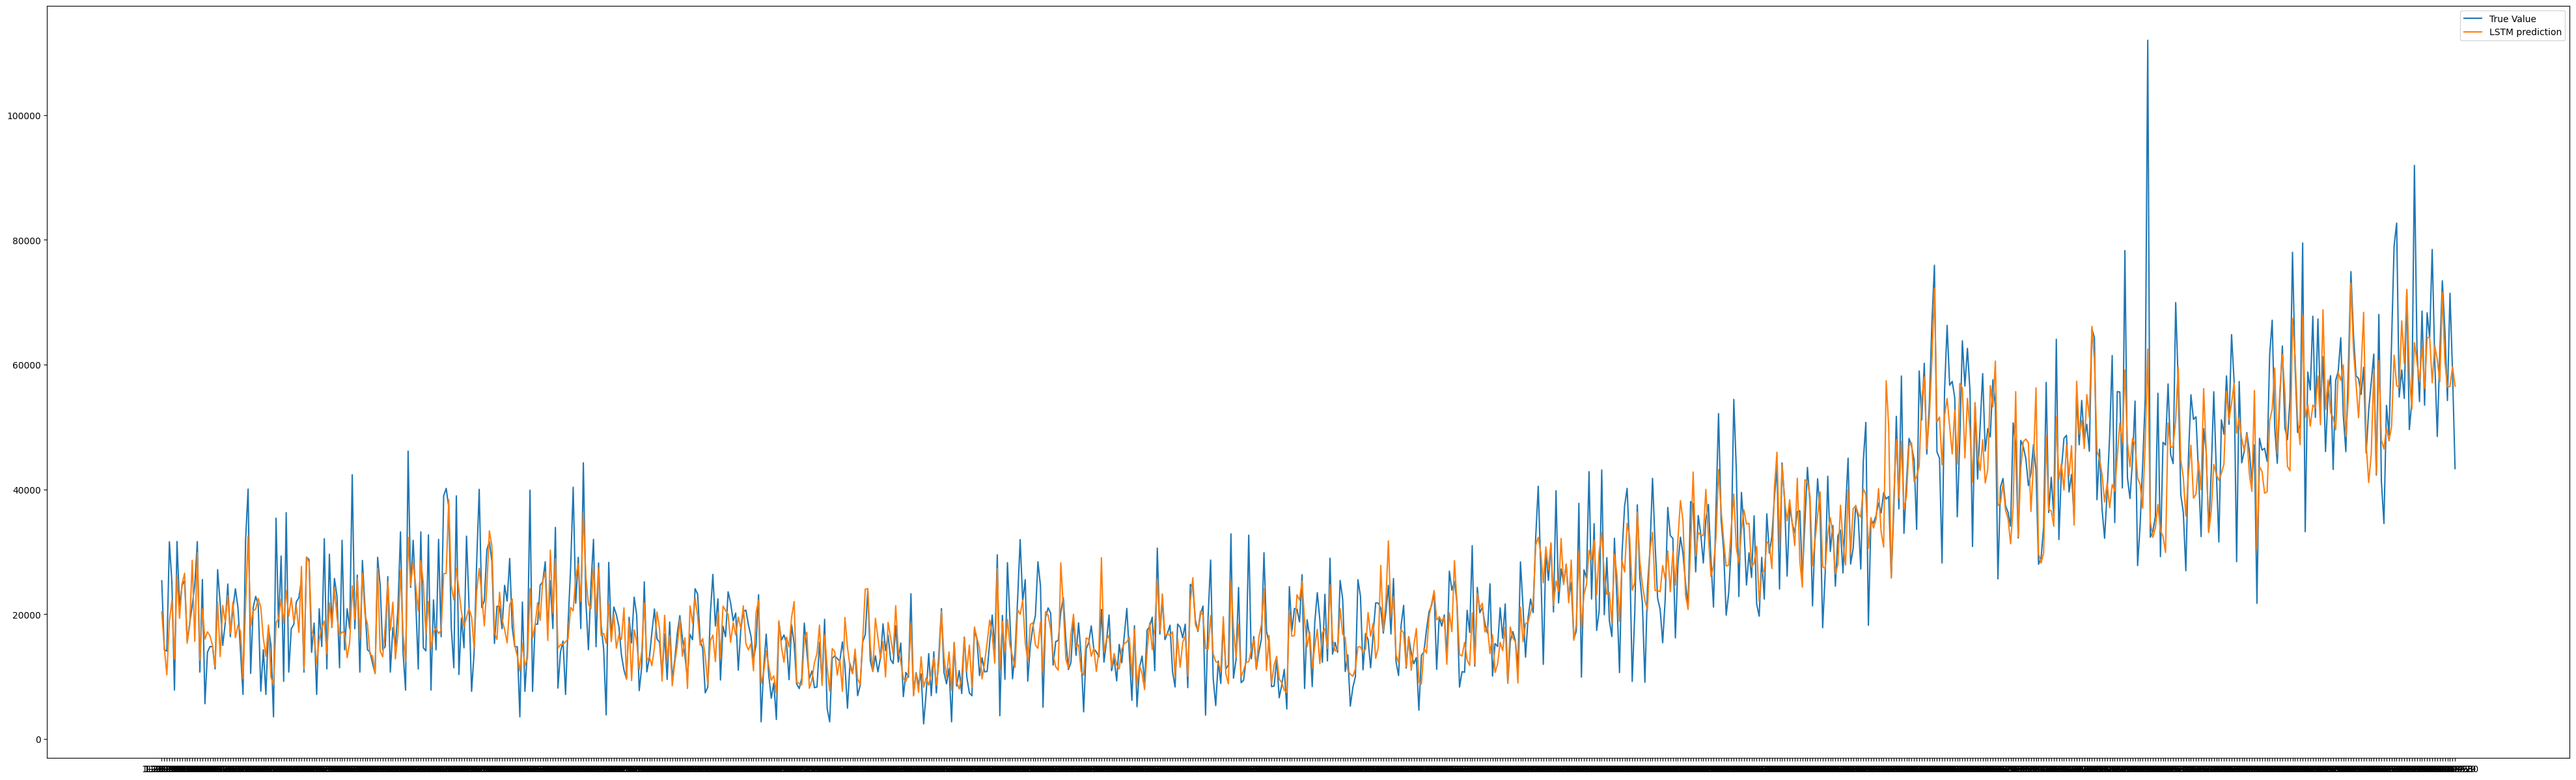

In [ ]:
plt.figure(figsize=(50,15))

plt.plot(train_data['month_year_date'].values, train_data['total_bill'].values, label="True Value")
plt.plot(train_data['month_year_date'].values, train_data['LSTM_pred'].values, label="LSTM prediction")

plt.legend()
plt.show()

In [ ]:
mse_lst.append(mean_squared_error(train_data['total_bill'],train_data['LSTM_pred']))
mae_lst.append(mean_absolute_error(train_data['total_bill'],train_data['LSTM_pred']))
model_lst.append('LSTM')

print(f'{model_lst[-1]}\nMAE:{mae_lst[-1]}\nMSE:{mse_lst[-1]}')

LSTM
MAE:4506.485006618156
MSE:39291223.56507389


# Conclusion

In [ ]:
result = pd.DataFrame({'model':model_lst,'MSE':mse_lst,'MAE':mae_lst})
result

model           MSE          MAE
0                MA  8.338891e+07  6848.756836
1               EMA  4.705238e+07  5143.066816
2           AutoReg  6.324758e+07  6000.889917
3             ARIMA  6.915089e+07  6216.605856
4  LinearRegression  4.303968e+07  4883.085354
5        ElasticNet  4.586759e+07  5003.442356
6  GradientBoosting  4.040025e+07  4830.464875
7              LSTM  3.929122e+07  4506.485007